**Technocolabs Softwares Internship mini project: Bank Depts**

Problem Statement:
After a debt has been legally declared "uncollectable" by a bank, the account is considered to be "charged-off." But that doesn't mean the bank simply walks away from the debt. They still want to collect some of the money they are owed. In this project, you will look at a situation where a bank assigned delinquent customers to different recovery strategies based on the expected amount the bank believed it would recover from the customer. The goal for the data scientist is to determine in this non-random assignment whether the incremental amount the bank earns exceeded the additional cost of assigning customers to a higher recovery strategy.
Threshold assignments like this also one occur in medicine (above a certain temperature you get medicine), education (above a certain test score students get admitted to a special class), other areas of finance (above a certain wealth customers get different levels of service), and public sector (below a certain income someone is eligible for housing benefits). Regression discontinuity is an intuitive and useful analysis method in any situation of a threshold assignment.

Importing Libraries

In [94]:
import numpy as np
import pandas as pd

# Data Visualisation Libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Train Test Split
from sklearn.model_selection import train_test_split

# Metrics
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import r2_score as R2


# ML Models
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor


Now that we loaded the libraries that we are going to need during the imple;entation of this project, let's load our Data and take a look at it

In [95]:
#load the data
from google.colab import files

uploaded = files.upload()

bank_data = pd.read_csv(next(iter(uploaded.keys())))


Saving bank_data.csv to bank_data (1).csv


In [96]:
#first look at the data

bank_data.head(10)

,id,expected_recovery_amount,actual_recovery_amount,recovery_strategy,age,sex
0,2030,194,263.540,Level 0 Recovery,19,Male
1,1150,486,416.090,Level 0 Recovery,25,Female
2,380,527,429.350,Level 0 Recovery,27,Male
3,1838,536,296.990,Level 0 Recovery,25,Male
4,1995,541,346.385,Level 0 Recovery,34,Male
5,731,548,520.710,Level 0 Recovery,35,Male
6,221,549,221.585,Level 0 Recovery,33,Male
7,1932,560,373.720,Level 0 Recovery,19,Female
8,1828,562,201.865,Level 0 Recovery,22,Female
9,2001,565,504.885,Level 0 Recovery,27,Male


In [97]:
# The shape of ou Data set
bank_data.shape

(1882, 6)

Regression Discontinuity: Banking recovery\
Key variables :

*   expected recovery amount
*   recovery strategy level
*   actual recovery amount
*   age
*   sexe

Levels and threshold:

*   Level 0: Expected recovery amounts >  0$ & <= 1000$
*   Level 1: Expected recovery amounts >  1000$ & <= 2000$
*   The threshold of $1000 separates Level 0 from Level

let's see how many customers in every recovery level and the thereshold of 1000$


In [98]:
bank_data['recovery_strategy'].value_counts()

Level 1 Recovery    670
Level 3 Recovery    368
Level 2 Recovery    333
Level 4 Recovery    264
Level 0 Recovery    247
Name: recovery_strategy, dtype: int64

<Axes: >

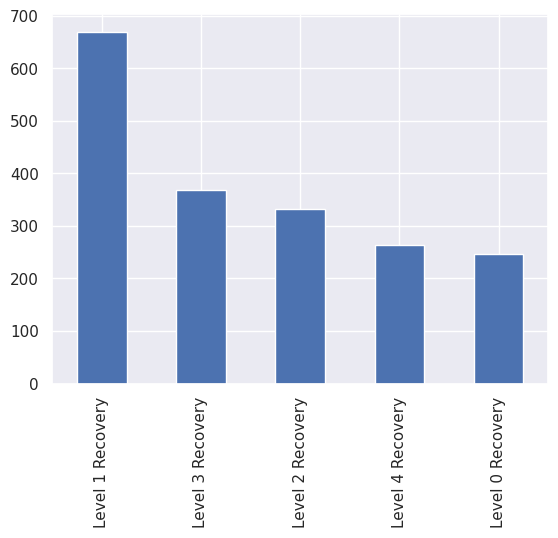

In [99]:
bank_data['recovery_strategy'].value_counts().plot(kind='bar')


Now Let's select a sample of customers that fall within a narrow range around the threshold (betweeen 900$ & 1100$)

Number of customers in the sample: 184


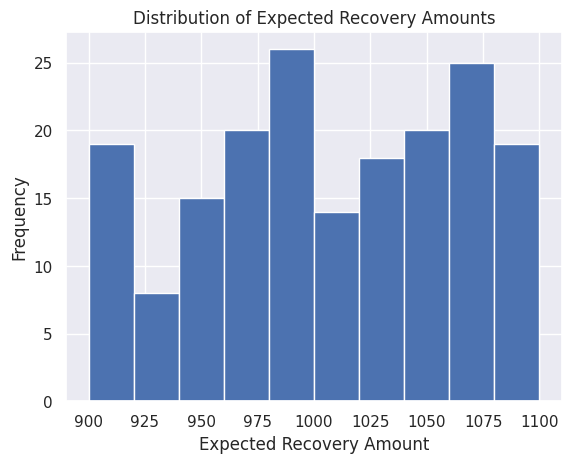

In [100]:
sample = bank_data[(bank_data['expected_recovery_amount'] >= 900) & (bank_data['expected_recovery_amount'] <= 1100)]

# Print the number of customers in the sample
print("Number of customers in the sample:", len(sample))

# you can plot the distribution of expected recovery amounts in the sample

plt.hist(sample['expected_recovery_amount'], bins=10)
plt.xlabel('Expected Recovery Amount')
plt.ylabel('Frequency')
plt.title('Distribution of Expected Recovery Amounts')
plt.show()

In [101]:
sample.head()

,id,expected_recovery_amount,actual_recovery_amount,recovery_strategy,age,sex
158,520,900,504.790,Level 0 Recovery,34,Male
159,1036,900,539.535,Level 0 Recovery,34,Female
160,1383,900,554.745,Level 0 Recovery,24,Male
161,998,901,887.005,Level 0 Recovery,32,Male
162,1351,903,667.035,Level 0 Recovery,28,Male


let's Create scatter plots to examine the relationship between the expected recovery amount (X-axis) and the actual recovery amount (Y-axis) for the selected sample.

let's take a look on the relation between the expected recovery amount and the actual recovery amount


<function matplotlib.pyplot.show(close=None, block=None)>

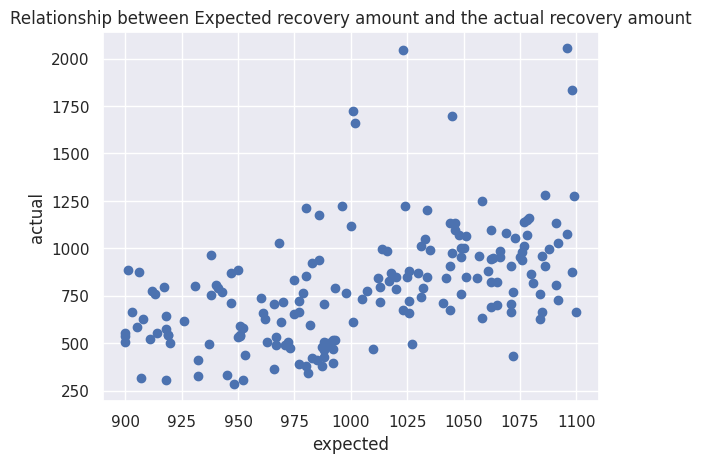

In [102]:
print("let's take a look on the relation between the expected recovery amount and the actual recovery amount")

plt.scatter(sample["expected_recovery_amount"], sample["actual_recovery_amount"])
plt.xlabel("expected")
plt.ylabel("actual")
plt.title("Relationship between Expected recovery amount and the actual recovery amount")
plt.show

Here, we can see that there is a big difference between the expected recovery amount and the actual recovery amount for some customers(expected recovery amount between 900 and 1100)

Data Cleaning

In [104]:
missings_values= bank_data.isnull().sum()
missings_values

id                          0
expected_recovery_amount    0
actual_recovery_amount      0
recovery_strategy           0
age                         0
sex                         0
dtype: int64

In [105]:
bank_data.duplicated().sum()

0

In [106]:
strategies=bank_data['recovery_strategy'].unique()
strategies

array(['Level 0 Recovery', 'Level 1 Recovery', 'Level 2 Recovery',
       'Level 3 Recovery', 'Level 4 Recovery'], dtype=object)

Statistical test: age vs. expected recovery amount

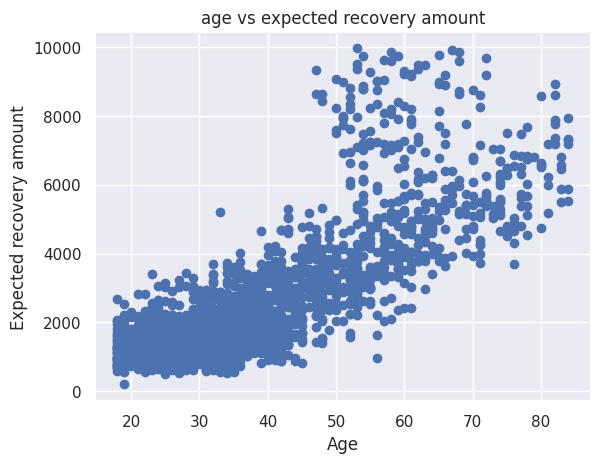

In [107]:
#let's do a scatter plot of age as a fucntion of the expected recovery amount

plt.scatter(bank_data['age'], bank_data['expected_recovery_amount'])
plt.xlabel('Age')
plt.ylabel('Expected recovery amount')
plt.title('age vs expected recovery amount')
plt.show()

As u can see, the greater the age is, the greater the expected recovery amount.

Now we will be covering a statistical test above and bellow the threshold of 1000$ (900$  -- 1100$), We already created a subset named Sample, we will be working on that subset for the moment

In [108]:
sample.head()

,id,expected_recovery_amount,actual_recovery_amount,recovery_strategy,age,sex
158,520,900,504.790,Level 0 Recovery,34,Male
159,1036,900,539.535,Level 0 Recovery,34,Female
160,1383,900,554.745,Level 0 Recovery,24,Male
161,998,901,887.005,Level 0 Recovery,32,Male
162,1351,903,667.035,Level 0 Recovery,28,Male


In [109]:
# average age above the threshold of 1000$
avg_age_above_threshold= sample[sample['expected_recovery_amount']<=1000]['age'].mean()

# average age bellow the thresholod of 1000$
avg_age_bellow_threshold = sample[sample['expected_recovery_amount']> 1000]['age'].mean()

print('the average age above the threshold is :', avg_age_above_threshold)
print("the average age bellow the threshold is :", avg_age_bellow_threshold)

the average age above the threshold is : 27.224719101123597
the average age bellow the threshold is : 28.68421052631579


In [110]:
import pandas as pd


# Convert 'Expected Recovery Amount' to numeric data type
sample['expected_recovery_amount'] = pd.to_numeric(sample['expected_recovery_amount'])

# Calculate the average age for customers above the threshold ($1000)
avg_age_above_threshold = sample[sample['expected_recovery_amount'] > 1000]['age'].mean()

# Calculate the average age for customers below the threshold ($1000)
avg_age_below_threshold = sample[sample['expected_recovery_amount'] <= 1000]['age'].mean()

# Perform an independent two-sample t-test
from scipy.stats import ttest_ind

t_stat, p_value = ttest_ind(sample[sample['expected_recovery_amount'] > 1000]['age'],
                           sample[sample['expected_recovery_amount'] <= 1000]['age'],
                           equal_var=False)

# Check the p-value to assess statistical significance
if p_value < 0.05:
    print("The difference in average age is statistically significant.")
else:
    print("There is no statistically significant difference in average age.")



There is no statistically significant difference in average age.


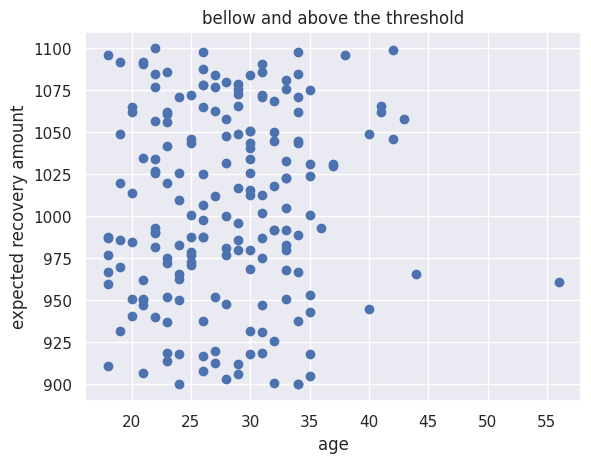

In [112]:
#scatter plot of the above and bellow of the threshold

plt.scatter(sample['age'], sample['expected_recovery_amount'])
plt.xlabel('age')
plt.ylabel('expected recovery amount')
plt.title('bellow and above the threshold')
plt.show()

Statistical test: sex vs. expected recovery amount

In [113]:
male_count = sample['sex'].value_counts()['Male']
female_count = sample['sex'].value_counts()['Female']
total_count = sample['sex'].count()

# Print the result
print("Number of Male:", male_count)
print("Number of Female:", female_count)
print("Total of value i Sex Columns:", total_count)

Number of Male: 112
Number of Female: 72
Total of value i Sex Columns: 184


In [114]:
#percentage of Male
perce_male = round((male_count/total_count)*100, 3)
perce_female = round((female_count/total_count)*100, 3)

print("The percentage of Male in our sample is :", perce_male,"%")
print("The precentage of Females in our sample is :", perce_female,"%")

The percentage of Male in our sample is : 60.87 %
The precentage of Females in our sample is : 39.13 %


Text(0, 0.5, 'Expected Recovery Amount')

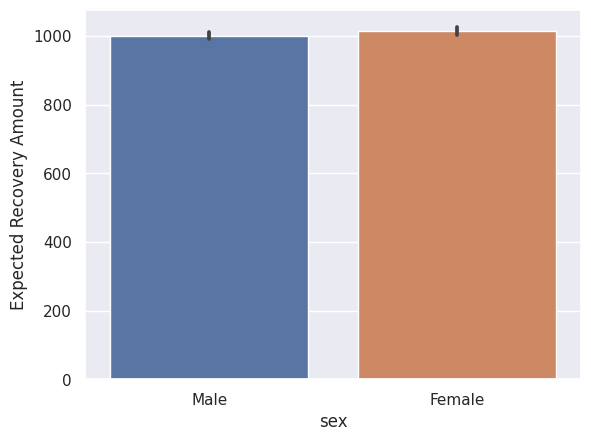

In [115]:
#let's plot The expected recovery amount as a function of sex

sns.barplot(x=sample['sex'], y=sample['expected_recovery_amount'])
plt.ylabel("Expected Recovery Amount")

Exploratory graphical analysis: recovery amount

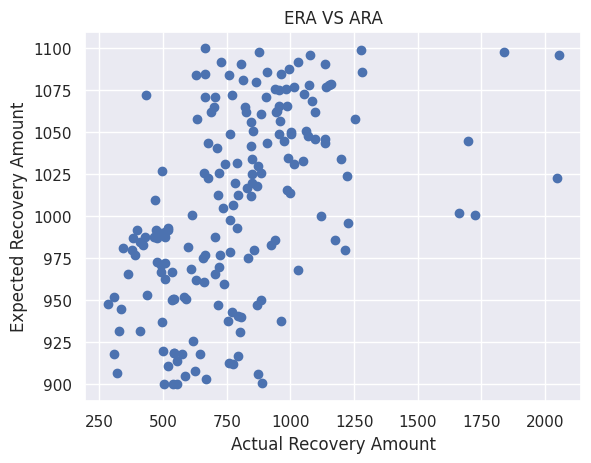

In [116]:
#scatter plot of Expected Recovery Amount VS Actual Recovery Amount
plt.scatter(sample['actual_recovery_amount'], sample['expected_recovery_amount'])
plt.xlabel("Actual Recovery Amount")
plt.ylabel("Expected Recovery Amount")
plt.title("ERA VS ARA")
plt.show()

Statistical analysis: recovery amount

In [117]:
# let's create a subset of range 950$ and 1050$

sample_2= bank_data[(bank_data['expected_recovery_amount'] >= 950) & (bank_data['expected_recovery_amount'] <= 1050)]

In [118]:
sample_2.head()

,id,expected_recovery_amount,actual_recovery_amount,recovery_strategy,age,sex
192,1619,950,883.790,Level 0 Recovery,21,Female
193,1898,950,534.910,Level 0 Recovery,24,Male
194,212,951,543.780,Level 0 Recovery,33,Female
195,1329,951,537.985,Level 0 Recovery,20,Male
196,1751,951,589.435,Level 0 Recovery,21,Male


In [119]:
from scipy.stats import kruskal

# Extract the actual recovery amounts for each window
actual_recovery_window_1 = sample['actual_recovery_amount']
actual_recovery_window_2 = sample_2['actual_recovery_amount']

# Perform the Kruskal-Wallis test for each window
statistic_1, p_value_1 = kruskal(actual_recovery_window_1, actual_recovery_window_2)

# Print the results for window 1
print("Kruskal-Wallis Test for Window 1")
print("Test Statistic:", statistic_1)
print("P-value:", p_value_1)

# Check for statistical significance for window 1
if p_value_1 < 0.05:
    print("There is a statistically significant difference in actual recovery amount for Window 1.")
else:
    print("There is no statistically significant difference in actual recovery amount for Window 1.")

# Perform the Kruskal-Wallis test for window 2
statistic_2, p_value_2 = kruskal(actual_recovery_window_2, actual_recovery_window_1)

# Print the results for window 2
print("Kruskal-Wallis Test for Window 2")
print("Test Statistic:", statistic_2)
print("P-value:", p_value_2)

# Check for statistical significance for window 2
if p_value_2 < 0.05:
    print("There is a statistically significant difference in actual recovery amount for Window 2.")
else:
    print("There is no statistically significant difference in actual recovery amount for Window 2.")


Kruskal-Wallis Test for Window 1
Test Statistic: 0.823820206138487
P-value: 0.36406558976551284
There is no statistically significant difference in actual recovery amount for Window 1.
Kruskal-Wallis Test for Window 2
Test Statistic: 0.823820206138487
P-value: 0.36406558976551284
There is no statistically significant difference in actual recovery amount for Window 2.


Regression modeling: no threshold

First we will chose our model that we wll be working with here, we chosed the RandomForest, now let's work on our model !!

In [120]:
no_threshold = sample[sample['expected_recovery_amount'] != 1000]

In [121]:
no_threshold

,id,expected_recovery_amount,actual_recovery_amount,recovery_strategy,age,sex
158,520,900,504.790000,Level 0 Recovery,34,Male
159,1036,900,539.535000,Level 0 Recovery,34,Female
160,1383,900,554.745000,Level 0 Recovery,24,Male
161,998,901,887.005000,Level 0 Recovery,32,Male
162,1351,903,667.035000,Level 0 Recovery,28,Male
...,...,...,...,...,...,...
337,1664,1096,2053.290126,Level 1 Recovery,18,Female
338,302,1098,876.997775,Level 1 Recovery,34,Male
339,554,1098,1836.918718,Level 1 Recovery,26,Female
340,1501,1099,1277.630578,Level 1 Recovery,42,Female


In [122]:
from sklearn.tree import DecisionTreeRegressor
# Chose the target
y=no_threshold['actual_recovery_amount']

# Chose the features
X=no_threshold['expected_recovery_amount']

# Split the data
train_X, test_X, train_y, test_y = train_test_split(X, y, random_state=0)

# RESHAPE THE DATA
train_X = train_X.to_numpy().reshape(-1, 1)
train_y = train_y.to_numpy()
test_X = test_X.to_numpy().reshape(-1, 1)

# Define the model
no_threshold_model = LinearRegression()

# Fit the model
no_threshold_model.fit(train_X, train_y)

# Prediction
no_threshold_predict = no_threshold_model.predict(test_X)

# Calculating the MEAN ABSOLUTE ERROR
no_threshold_mae = MAE(test_y, no_threshold_predict)
no_threshold_mse = MSE(test_y, no_threshold_predict)
print("The Mean Absolute Error for this model is :", no_threshold_mae)
print("The Mean Squared Error for this Model is :", no_threshold_mse)

# Calculate R-squared
r_squared = R2(test_y, no_threshold_predict)
print("R-squared:", r_squared)

# Print the model's coefficients and intercept
print("Coefficients:", no_threshold_model.coef_)
print("Intercept:", no_threshold_model.intercept_)

The Mean Absolute Error for this model is : 217.20015344104274
The Mean Squared Error for this Model is : 91436.53335457956
R-squared: 0.30528018541353685
Coefficients: [2.28973976]
Intercept: -1507.459286005433


Regression modeling: adding true threshold

Now, we eill create the model of the samole we created that conatains the threshold of 1000$        

In [123]:
# Chose the target
y=sample['actual_recovery_amount']

# Chose the features
X=sample['expected_recovery_amount']

# Split the data
train_X, test_X, train_y, test_y = train_test_split(X, y, random_state=0)

# RESHAPE THE DATA
train_X = train_X.to_numpy().reshape(-1, 1)
train_y = train_y.to_numpy()
test_X = test_X.to_numpy().reshape(-1, 1)

# Define the model
with_threshold_model = LinearRegression()

# Fit the model
with_threshold_model.fit(train_X, train_y)

# Prediction
with_threshold_predict = with_threshold_model.predict(test_X)

# Calculating the MEAN ABSOLUTE ERROR
with_threshold_mae = MAE(test_y, with_threshold_predict)
with_threshold_mse = MSE(test_y, with_threshold_predict)
print("The Mean Absolute Error for this model is :", with_threshold_mae)
print("The Mean Squared Error for this Model is :", with_threshold_mse)

# Calculate R-squared
r_squared = R2(test_y, no_threshold_predict)
print("R-squared:", r_squared)

# Print the model's coefficients and intercept
print("Coefficients:", with_threshold_model.coef_)
print("Intercept:", with_threshold_model.intercept_)

The Mean Absolute Error for this model is : 174.6243882482685
The Mean Squared Error for this Model is : 44316.07880312399
R-squared: -0.43032236570241356
Coefficients: [2.70969648]
Intercept: -1918.2095703191662


Regression modeling: adjusting the window

At this point, we will be working on the window of 950 to 1050$ that we already created and named sample_2, first we will remove the threshold as we did before with the fist window

In [124]:
sample_2_no_threshold = sample_2[sample_2['expected_recovery_amount']!=1000]
sample_2_no_threshold

,id,expected_recovery_amount,actual_recovery_amount,recovery_strategy,age,sex
192,1619,950,883.790000,Level 0 Recovery,21,Female
193,1898,950,534.910000,Level 0 Recovery,24,Male
194,212,951,543.780000,Level 0 Recovery,33,Female
195,1329,951,537.985000,Level 0 Recovery,20,Male
196,1751,951,589.435000,Level 0 Recovery,21,Male
...,...,...,...,...,...,...
287,1557,1048,1068.511941,Level 1 Recovery,28,Female
288,192,1049,955.913183,Level 1 Recovery,19,Male
289,1086,1049,760.897712,Level 1 Recovery,29,Male
290,1336,1049,1002.450251,Level 1 Recovery,40,Male


In [125]:
# Chose the target
y=sample_2_no_threshold['actual_recovery_amount']

# Chose the features
X=sample_2_no_threshold['expected_recovery_amount']

# Split the data
train_X, test_X, train_y, test_y = train_test_split(X, y, random_state=0)

# RESHAPE THE DATA
train_X = train_X.to_numpy().reshape(-1, 1)
train_y = train_y.to_numpy()
test_X = test_X.to_numpy().reshape(-1, 1)

# Define the model
sample_2_no_threshold_model = LinearRegression()

# Fit the model
sample_2_no_threshold_model.fit(train_X, train_y)

# Prediction
sample_2_no_threshold_predict = sample_2_no_threshold_model.predict(test_X)

# Calculating the MEAN ABSOLUTE ERROR
sample_2_no_threshold_model_mae = MAE(test_y, sample_2_no_threshold_predict)
sample_2_no_threshold_model_mse = MSE(test_y, sample_2_no_threshold_predict)
print("The Mean Absolute Error for this model is :", sample_2_no_threshold_model_mae)
print("The Mean Squared Error for this Model is :", sample_2_no_threshold_model_mse)

# Calculate R-squared
r_squared = R2(test_y, sample_2_no_threshold_predict)
print("R-squared:", r_squared)

# Print the model's coefficients and intercept
print("Coefficients:", sample_2_no_threshold_model.coef_)
print("Intercept:", sample_2_no_threshold_model.intercept_)

The Mean Absolute Error for this model is : 221.33886812037213
The Mean Squared Error for this Model is : 101509.93174669733
R-squared: 0.1737677647693917
Coefficients: [5.07901064]
Intercept: -4332.332240552097


Now we will do the same but this time with the threshold

In [126]:
# Chose the target
y=sample_2['actual_recovery_amount']

# Chose the features
X=sample_2['expected_recovery_amount']

# Split the data
train_X, test_X, train_y, test_y = train_test_split(X, y, random_state=0)

# RESHAPE THE DATA
train_X = train_X.to_numpy().reshape(-1, 1)
train_y = train_y.to_numpy()
test_X = test_X.to_numpy().reshape(-1, 1)

# Define the model
with_threshold_model_2 = LinearRegression()

# Fit the model
with_threshold_model_2.fit(train_X, train_y)

# Prediction
with_threshold_predict_2 = with_threshold_model_2.predict(test_X)

# Calculating the MEAN ABSOLUTE ERROR
with_threshold_mae_2 = MAE(test_y, with_threshold_predict_2)
with_threshold_mse_2 = MSE(test_y, with_threshold_predict_2)
print("The Mean Absolute Error for this model is :", with_threshold_mae_2)
print("The Mean Squared Error for this Model is :", with_threshold_mse_2)

# Calculate R-squared
r_squared = R2(test_y, with_threshold_predict_2)
print("R-squared:", r_squared)

# Print the model's coefficients and intercept
print("Coefficients:", with_threshold_model_2.coef_)
print("Intercept:", with_threshold_model_2.intercept_)

The Mean Absolute Error for this model is : 253.0082215317538
The Mean Squared Error for this Model is : 162528.5204955022
R-squared: 0.0542558757456616
Coefficients: [4.64648495]
Intercept: -3918.3780820151997
